In [1]:
# Main repo here for pytorch
# https://github.com/timesler/facenet-pytorch


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
# from facenet_pytorch import InceptionResnetV1


c:\Users\Pc\miniconda3\envs\gait\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
import csv


class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images_info = []

        # List all video files in the root directory and assign labels
        self.label_to_id = {}  # Create a dictionary to map labels to unique IDs
        label_id = 0
        for person_folder in os.listdir(root_dir):
            person_path = os.path.join(root_dir, person_folder)
            if os.path.isdir(person_path):
                self.label_to_id[person_folder] = label_id
                for image_file in os.listdir(person_path):
                    if image_file.endswith('.png'):
                        self.images_info.append((os.path.join(person_path, image_file), label_id))
            label_id += 1
        
        self.filename_polygons_ellipses = {}
        with open("./shapes_dataset_HR/labels.csv", 'r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                filename = row['Filename']
                num_polygons = int(row['NumOfPolygons'])
                num_ellipses = int(row['NumOfEllipses'])
                self.filename_polygons_ellipses[filename] = (num_polygons, num_ellipses)
        
        # print(self.label_to_id)
    # def load_csv(csv_file_path = "./shapes_dataset_HR/labels.csv"):
    #     # Read the CSV file and store the information in a dictionary
    #     self.filename_polygons_ellipses = {}
    #     with open(csv_file_path, 'r') as file:
    #         reader = csv.DictReader(file)
    #         for row in reader:
    #             filename = row['Filename']
    #             num_polygons = int(row['NumOfPolygons'])
    #             num_ellipses = int(row['NumOfEllipses'])
    #             self.filename_polygons_ellipses[filename] = (num_polygons, num_ellipses)
    
    def __len__(self):
        return len(self.images_info)

    def __getitem__(self, idx):
        image_path, label = self.images_info[idx]
        image = self.load_image(image_path)
        sample_image_name = os.path.basename(image_path)
        polygon = self.filename_polygons_ellipses[sample_image_name][1]
        ellipse = self.filename_polygons_ellipses[sample_image_name][0]
        if self.transform:
            image = self.transform(image)
        # print(image.shape, ellipse, polygon)
        return image, ellipse, polygon


    def load_image(self, image_path):
        # Load video frames using OpenCV
        # image = cv2.imread(image_path).astype(np.float64)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.imread(image_path).astype(np.float32)/255.
        # image = cv2.imread(image_path)
        # print(image.shape, image_path)
        # image = np.transpose(image, (2, 0, 1))
        return image

In [32]:
print(os.path.basename("./shapes_dataset_HR\\0\\test0017.png").split('.')[0])

test0017


In [43]:
IMG_SIZE = 224
BATCH_SIZE = 128

data_transform = transforms.Compose([
    # transforms.ToPILImage(),
    # transforms.Resize((IMG_SIZE, IMG_SIZE)),
    
   
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomVerticalFlip(),    # Apply random vertical flip
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Lambda(lambda x: x / 128.0)  # Normalize by dividing by 255
])



seed = 42
generator = torch.Generator(device='cuda')
generator.manual_seed(seed)


root_dir = './shapes_dataset_HR'
dataset = ImageDataset("./train", transform = data_transform)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True )

# print(dataset.images_info)



        

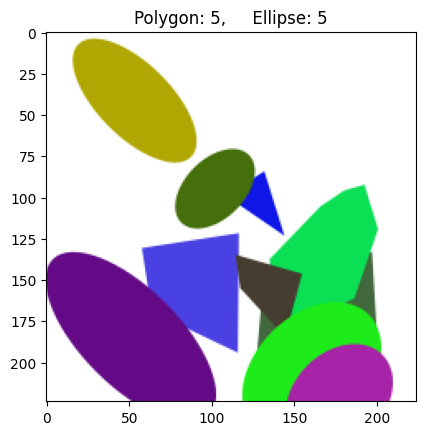

In [44]:

def plot_loader(train_loader, total_to_show = 4):
    for  total_frames , polygon, ellipse in train_loader:
        for i, frames in enumerate(total_frames):
            # print(frames.shape)
            show_frame = np.transpose(frames.numpy(), (1, 2, 0))
            plt.title(f"Polygon: {polygon[i]},     Ellipse: {ellipse[i]}")
            plt.imshow(show_frame,cmap='viridis', norm=None)
            if i == total_to_show:
                break
        break
plot_loader(train_loader)

In [45]:
NUM_CLASSES = len(dataset.label_to_id)
print(NUM_CLASSES)
NUM_EPOCHS = 100

6


In [47]:
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm

# Define a function to compute accuracy
def compute_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    accuracy = correct / total
    return accuracy


class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.model = models.resnet101(pretrained=True)
        # self.model  = InceptionResnetV1(pretrained='casia-webface').eval()
        # self.model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

        out_feature = self.model.fc.out_features
        # out_feature = 1000
        self.linear1 = nn.Linear(out_feature, 512)
        self.linear2 = nn.Linear(512, num_classes)
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.model(x)
        output = self.linear1(features)
        output = self.linear2(output)
        return output


class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(56180, 50)
        self.fc2 = nn.Linear(50, num_classes)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)


print(NUM_CLASSES)
model = CustomResNet(num_classes=NUM_CLASSES)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

loss_function = nn.CrossEntropyLoss()

# Step 4: Train your model
# Example:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0
    tqdm_obj = tqdm(train_loader)
    for images, polygon, ellipse in tqdm_obj:
        if torch.cuda.is_available():
            images, polygon, ellipse = images.to(device), polygon.to(device), ellipse.to(device)
        
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, ellipse)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == ellipse).sum().item()
        total += ellipse.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct / total
        tqdm_obj.set_description(desc=f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}')
    


6


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\Pc/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
 82%|████████▏ | 140M/171M [01:35<00:39, 811kB/s]  

Confusion Matrix:
[[528  38   1   1   0   0]
 [ 32 467  71  22   3   1]
 [  9 119 266 172  35   3]
 [  2  36  86 287 116  66]
 [  1   6  25 161 234 200]
 [  0   2   6  90 123 418]]


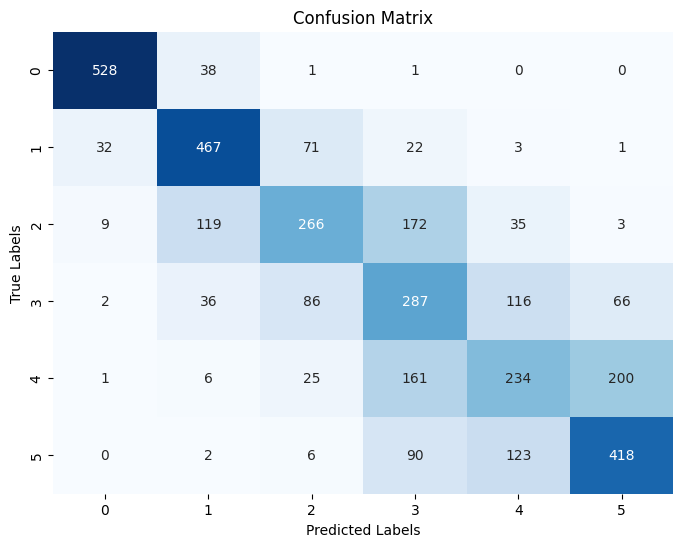

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = []
predicted_labels = []

# Put the model in evaluation mode
model.eval()

test_dataset = ImageDataset("./test", transform = data_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True )


# Disable gradient calculation
with torch.no_grad():
    for images, polygon, ellipse in test_loader:
        images, polygon = images.to(device), polygon.to(device)  # Move data to GPU
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(polygon.cpu().numpy())  # Move ground truth labels to CPU and convert to numpy array
        predicted_labels.extend(predicted.cpu().numpy())  # Move predicted labels to CPU and convert to numpy array

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print or use the confusion matrix as needed
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()